# Create Locally Refined Grid for McDonald Valley Problem

## Load Modules and Setup Notebook

In [26]:
import os
import sys
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import flopy

from flopy.utils.gridgen import read1d
from flopy.utils.lgrutil import Lgr

print(sys.version)
print('numpy version: {}'.format(np.__version__))
print('matplotlib version: {}'.format(mpl.__version__))
print('flopy version: {}'.format(flopy.__version__))

3.7.3 (default, Mar 27 2019, 16:54:48) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
numpy version: 1.16.2
matplotlib version: 3.0.3
flopy version: 3.2.12


## Create Parent Grid

In [27]:
nlay = 5
nrow = 40
ncol = 25
delr = 500.
delc = 500.
top = 100.
botm = np.zeros((nlay, nrow, ncol), dtype=np.float32)
botm[0] = -5.
botm[1] = -50
botm[2] = -51
botm[3] = -100
fname = './data/bottom.csv'
botm[4] = np.loadtxt(fname, delimiter=',')

Text(0.5, 1.0, 'kclay: 0.003 200.0')

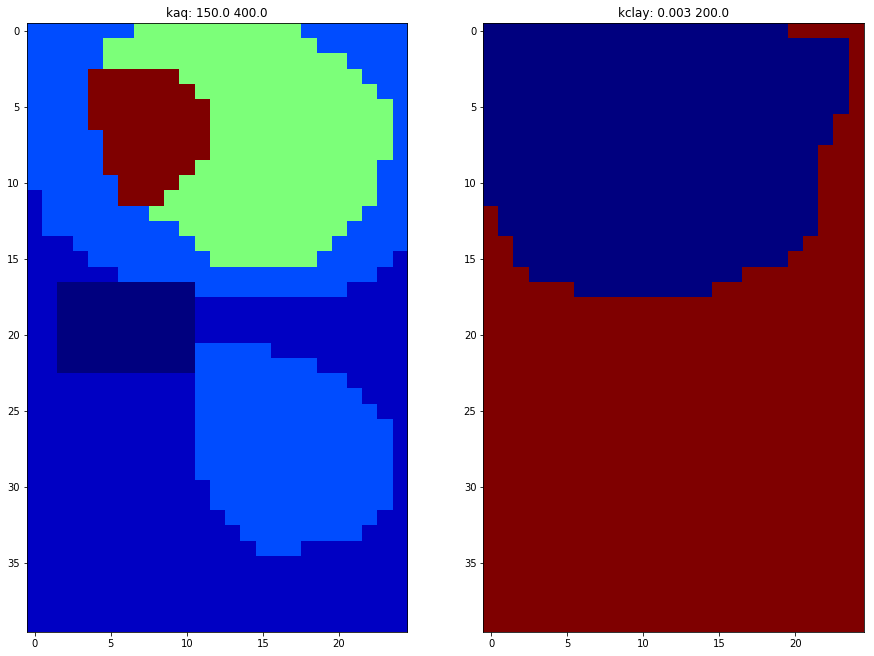

In [28]:
# gridded information (aquifer and clay k values)
kaq = np.loadtxt('./data/k_aq.csv', delimiter=',')

kclay = np.empty((nrow * ncol), dtype=np.float)
f = open('./data/k_clay.txt', 'r')
kclay = read1d(f, kclay).reshape((nrow, ncol))

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(1, 2, 1, aspect='equal')
ax.imshow(kaq, vmin=kaq.min(), vmax=kaq.max(), cmap='jet')
ax.set_title('kaq: {} {}'.format(kaq.min(), kaq.max()))

ax = fig.add_subplot(1, 2, 2, aspect='equal')
ax.imshow(kclay, vmin=kclay.min(), vmax=kclay.max(), cmap='jet')
ax.set_title('kclay: {} {}'.format(kclay.min(), kclay.max()))

In [29]:
# lake cell locations
chdspd = []
for  line in open('./data/lake_data_chd.txt', 'r').readlines():
    k, i, j, stage = line.strip().split()
    chdspd.append([(int(k) - 1, int(i) - 1, int(j) - 1), float(stage)])

In [30]:
# boundary conditions
welspd = [[(3 - 1, 11 - 1, 10 - 1), -1.5e5]]
rech = 0.005

rivspd = []
stage = np.linspace(1.75, .05, 18)
for iriv in range(18):
    rivspd.append([(0, iriv + 22, 8), stage[iriv], 1.e5, -2.])

In [31]:
ws = './model'
name = 'mv'
sim = flopy.mf6.MFSimulation(sim_ws=ws, sim_name=name, exe_name='mf6')
tdis = flopy.mf6.ModflowTdis(sim)
ims = flopy.mf6.ModflowIms(sim, complexity='complex')
gwf = flopy.mf6.ModflowGwf(sim, save_flows=True)
dis = flopy.mf6.ModflowGwfdis(gwf, nlay=nlay, nrow=nrow, ncol=ncol,
                              delr=delr, delc=delc, top=top, botm=botm)
ic = flopy.mf6.ModflowGwfic(gwf, strt=11.)
npf = flopy.mf6.ModflowGwfnpf(gwf, 
                              save_specific_discharge=True,
                              icelltype=[1, 0, 0, 0, 0],
                              k=[kaq, kaq, kclay, kaq, kaq],
                              k33=[0.25 * kaq, 0.25 * kaq, kclay, 0.25 * kaq, 0.25 * kaq])
chd = flopy.mf6.ModflowGwfchd(gwf, stress_period_data=chdspd)
rch = flopy.mf6.ModflowGwfrcha(gwf, recharge=.003641)
riv = flopy.mf6.ModflowGwfriv(gwf, stress_period_data=rivspd)
budget_file = name + '.bud'
head_file = name + '.hds'
oc = flopy.mf6.ModflowGwfoc(gwf,
                            budget_filerecord=budget_file,
                            head_filerecord=head_file,
                            saverecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')])
sim.write_simulation()
sim.run_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims_-1...
  writing model model...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package chd_0...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 65 based on size of stress_period_data
    writing package rcha...
    writing package riv_0...
INFORMATION: maxbound in ('gwf6', 'riv', 'dimensions') changed to 18 based on size of stress_period_data
    writing package oc...
FloPy is using the following  executable to run the model: /Users/langevin/langevin/bin/mac/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.0.4 03/13/2019

  MODFLOW 6 compiled Mar 14 2019 09:20:00 with GFORTRAN compiler (ver. 8.2.0)

This software has been approved for release by the U.S. Geological 
Survey (USG

(True, [])

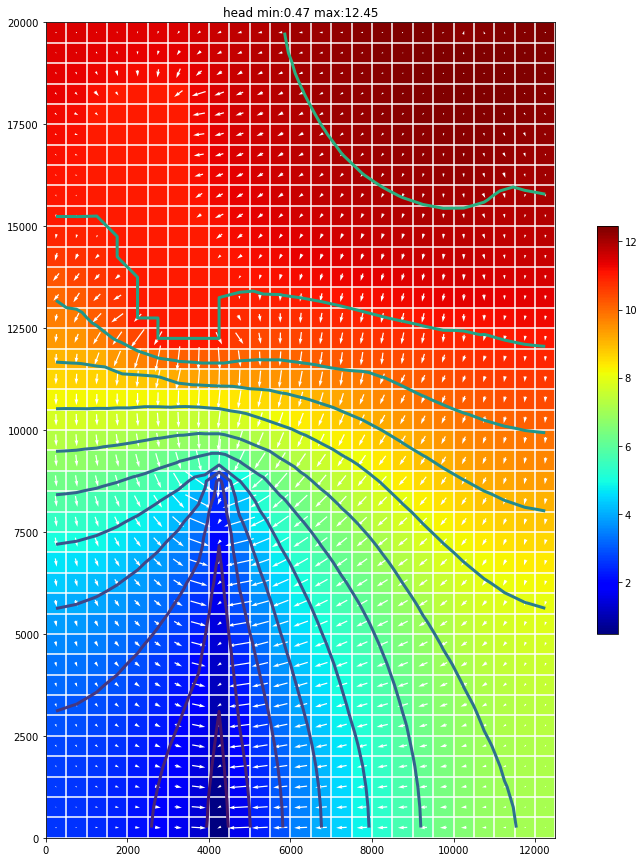

In [32]:
head = flopy.utils.HeadFile(os.path.join(ws, head_file)).get_data()
bud = flopy.utils.CellBudgetFile(os.path.join(ws, budget_file),
                                 precision='double')
spdis = bud.get_data(text='DATA-SPDIS')[0]

ilay = 0
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
pmv = flopy.plot.PlotMapView(gwf, ax=ax, layer=ilay)
quadmesh = pmv.plot_array(head, cmap='jet')
pmv.plot_grid(colors='white')
pmv.contour_array(head, levels=np.arange(20), linewidths=3.)
pmv.plot_specific_discharge(spdis, color='white')
ax.set_title('head min:{:.2f} max:{:.2f}'.format(head[ilay].min(), head[ilay].max()))
plt.colorbar(quadmesh, shrink=0.5)

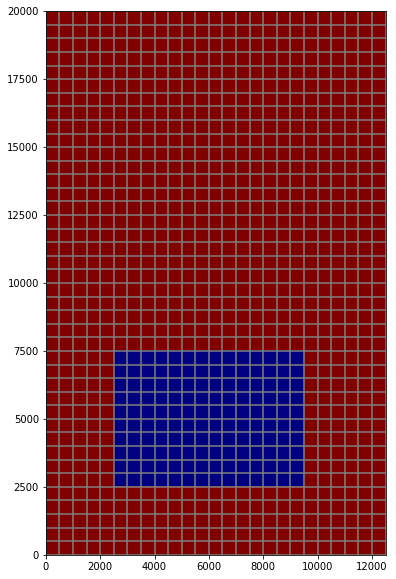

In [33]:
# Set the idomain of the parent model in order to 
# define where the child model will be located
idomain = np.ones((nlay, nrow, ncol), dtype=np.int)
idrowstart = 25
idrowend = 34
idcolstart = 5
idcolend = 18
idomain[0:5, idrowstart:idrowend + 1, idcolstart:idcolend + 1] = 0

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
pmv = flopy.plot.PlotMapView(gwf, ax=ax, layer=ilay)
quadmesh = pmv.plot_array(idomain, cmap='jet')
pmv.plot_grid()

In [34]:
# create the flopy Lgr object to help define the child model
ncpp = 3
ncppl = nlay * [1]
lgr = Lgr(nlay, nrow, ncol, delr, delc, top, botm,
            idomain, ncpp, ncppl)

cnlay, cnrow, cncol = lgr.get_shape()
cdelr, cdelc = lgr.get_delr_delc()
ctop, cbotm = lgr.get_top_botm()
xorigin, yorigin = lgr.get_lower_left()
cidomain = lgr.get_idomain()


/Users/langevin/langevin/dev/flopy3fork.git/flopy/utils/util_array.py:1708: UserWarning: Util2d: setting integer dtype from int64 to int32
  .format(dtype))


In [35]:
# boundary conditions
welspd = [[(3 - 1, 11 - 1, 10 - 1), -1.5e5]]
rech = 0.005

rivspd = []
stage = np.linspace(1.75, .05, 18)
for iriv in range(18):
    irowriv = iriv + 22
    if irowriv < idrowstart or irowriv > idrowend:
        rivspd.append([(0, irowriv, 8), stage[iriv], 1.e5, -2.])

In [36]:
ws = './model'
name = 'mv'
sim = flopy.mf6.MFSimulation(sim_ws=ws, sim_name=name, exe_name='mf6')
tdis = flopy.mf6.ModflowTdis(sim)
ims = flopy.mf6.ModflowIms(sim, complexity='complex')
gwf = flopy.mf6.ModflowGwf(sim, modelname=name, save_flows=True)
dis = flopy.mf6.ModflowGwfdis(gwf, nlay=nlay, nrow=nrow, ncol=ncol,
                              delr=delr, delc=delc, top=top, botm=botm,
                              idomain=idomain)
ic = flopy.mf6.ModflowGwfic(gwf, strt=11.)
npf = flopy.mf6.ModflowGwfnpf(gwf, 
                              save_specific_discharge=True,
                              icelltype=[1, 0, 0, 0, 0],
                              k=[kaq, kaq, kclay, kaq, kaq],
                              k33=[0.25 * kaq, 0.25 * kaq, kclay, 0.25 * kaq, 0.25 * kaq])
chd = flopy.mf6.ModflowGwfchd(gwf, stress_period_data=chdspd)
rch = flopy.mf6.ModflowGwfrcha(gwf, recharge=.003641)
riv = flopy.mf6.ModflowGwfriv(gwf, stress_period_data=rivspd)
budget_file = name + '.bud'
head_file = name + '.hds'
oc = flopy.mf6.ModflowGwfoc(gwf,
                            budget_filerecord=budget_file,
                            head_filerecord=head_file,
                            saverecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')])


# create child gwf model
cmodel_name = 'child'
cgwf = flopy.mf6.ModflowGwf(sim, modelname=cmodel_name,
                           model_nam_file='{}.nam'.format(cmodel_name))
cgwf.name_file.save_flows = True
cdis = flopy.mf6.ModflowGwfdis(cgwf, nlay=cnlay, nrow=cnrow, ncol=cncol,
                               delr=cdelr, delc=cdelc,
                               top=ctop, botm=cbotm, idomain=cidomain,
                               xorigin=xorigin, yorigin=yorigin)
cic = flopy.mf6.ModflowGwfic(cgwf, pname='ic', strt=11.)
ckaq = lgr.get_replicated_parent_array(kaq)
ckclay = lgr.get_replicated_parent_array(kclay)
cnpf = flopy.mf6.ModflowGwfnpf(cgwf, save_specific_discharge=True,
                              icelltype=[1, 0, 0, 0, 0], 
                              k=[ckaq, ckaq, ckclay, ckaq, ckaq],
                              k33=[0.25 * ckaq, 0.25 * ckaq, ckclay, 0.25 * ckaq, 0.25 * ckaq])

rch = flopy.mf6.ModflowGwfrcha(cgwf, recharge=.003641)

crivspd = []
_, ichildrivcol = cgwf.modelgrid.intersect(4250, yorigin + 1)
for irowriv in range(cnrow):
    crivspd.append([(0, irowriv, ichildrivcol), stage.mean(), 1.e5, -2])
riv = flopy.mf6.ModflowGwfriv(cgwf, stress_period_data=crivspd)
#welspd = [[(cnlay - 1, int(cnrow / 2), int(cncol / 2)), -1.5e5]]
#wel = flopy.mf6.ModflowGwfwel(cgwf, print_input=True,
#                              stress_period_data=welspd)
oc = flopy.mf6.ModflowGwfoc(cgwf, pname='oc', budget_filerecord='{}.bud'.format(cmodel_name),
                            head_filerecord='{}.hds'.format(cmodel_name),
                            headprintrecord=[('COLUMNS', 10, 'WIDTH', 15,
                                              'DIGITS', 6, 'GENERAL')],
                            saverecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')],
                            printrecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')])

# exchange information
exchangedata = lgr.get_exchange_data(angldegx=True, cdist=True)
nexg = len(exchangedata)
gwfe = flopy.mf6.ModflowGwfgwf(sim, exgtype='gwf6-gwf6', 
                               exgmnamea=name, exgmnameb=cmodel_name, 
                               nexg=nexg, auxiliary=['angldegx', 'cdist'], 
                               exchangedata=exchangedata)

sim.write_simulation()
sim.run_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims_-1...
  writing package mv.gwfgwf...
  writing model mv...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package chd_0...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 65 based on size of stress_period_data
    writing package rcha...
    writing package riv_0...
INFORMATION: maxbound in ('gwf6', 'riv', 'dimensions') changed to 8 based on size of stress_period_data
    writing package oc...
  writing model child...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package rcha...
    writing package riv_0...
INFORMATION: maxbound in ('gwf6', 'riv', 'dimensions') changed to 30 based on size of stress_period_data
    writing package oc...
FloPy is using the following  executable to run the model: /Users/

(True, [])

(0, 20000)

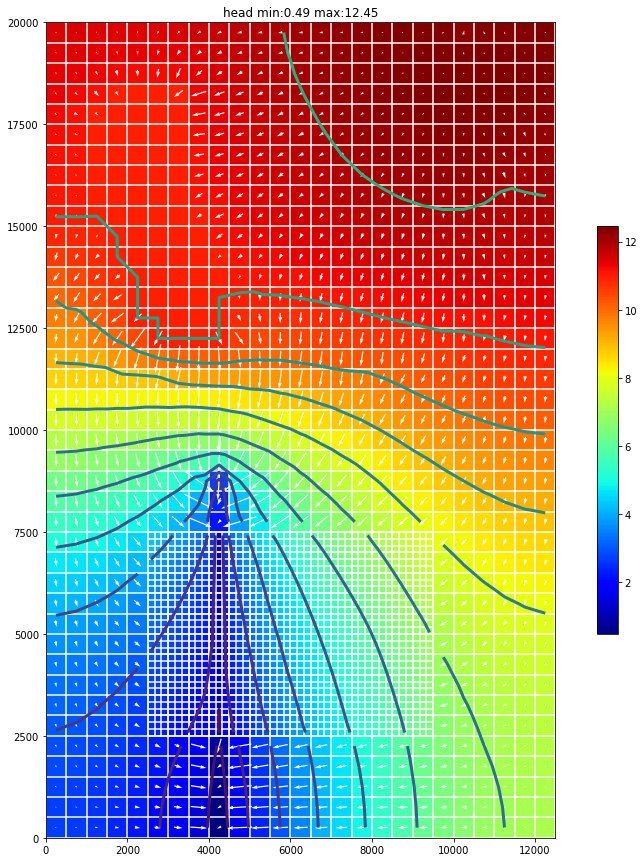

In [37]:
# parent
head = flopy.utils.HeadFile(os.path.join(ws, head_file)).get_data()
bud = flopy.utils.CellBudgetFile(os.path.join(ws, budget_file),
                                 precision='double')
spdis = bud.get_data(text='DATA-SPDIS')[0]
head = np.ma.masked_equal(head, 1.e30)

# child
chead = flopy.utils.HeadFile(os.path.join(ws, cmodel_name + '.hds')).get_data()
cbud = flopy.utils.CellBudgetFile(os.path.join(ws, cmodel_name + '.bud'),
                                 precision='double')
cspdis = cbud.get_data(text='DATA-SPDIS')[0]

ilay = 0
vmin = min(head[ilay].min(), chead[ilay].min())
vmax = max(head[ilay].max(), chead[ilay].max())

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
pmv = flopy.plot.PlotMapView(gwf, ax=ax, layer=ilay)
quadmesh = pmv.plot_array(head, cmap='jet', vmin=vmin, vmax=vmax)
pmv.plot_grid(colors='white')
pmv.contour_array(head, levels=np.arange(20), linewidths=3.)
pmv.plot_specific_discharge(spdis, color='white')
ax.set_title('head min:{:.2f} max:{:.2f}'.format(head[ilay].min(), head[ilay].max()))
plt.colorbar(quadmesh, shrink=0.5)


pmv = flopy.plot.PlotMapView(cgwf, ax=ax, layer=ilay)
quadmesh = pmv.plot_array(chead, cmap='jet', vmin=vmin, vmax=vmax)
pmv.plot_grid(colors='white')
pmv.contour_array(chead, levels=np.arange(20), linewidths=3.)
#pmv.plot_specific_discharge(cspdis, color='white')

ax.set_xlim(0, 12500)
ax.set_ylim(0, 20000)

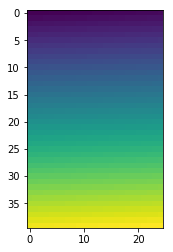